In [3]:
%%capture
! unzip New\ folder.zip

In [1]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
def single_file_parser(f):
    content = f.readlines()
    numbers = []
    for word in content:
        tmp = ''
        for x in word:
            if(x == ','):
                numbers.append(tmp)
                tmp = ''
            else:
                tmp = tmp + x

    data_list = []
    data_container = []
    for number in numbers:
        if(number == '|'):
            data_container.append(data_list)
            data_list=[]
        else:
            data_list.append(number)

    sensor_data = []
    checksum=0
    tmp = []
    for measurement in data_container:
        for data in measurement[70:]:
            if(int(data)==0):
                checksum=0
            elif(checksum==0):
                tmp.append(int(data))
                checksum=1
        sensor_data.append(tmp)
        tmp=[]

    packet = []
    data = []
    j=1
    for i in range(0,len(sensor_data)):
        packet.extend(sensor_data[i])
        if(j%3==0):
            data.append(packet)
            packet=[]
        j=j+1

    return data

def single_file_parser_2(f):
    content = f.readlines()
    numbers = []
    for word in content:
        tmp = ''
        for x in word:
            if(x == ','):
                numbers.append(tmp)
                tmp = ''
            else:
                tmp = tmp + x

    data_list = []
    data_container = []
    for number in numbers:
        if(number == '|'):
            data_container.append(data_list)
            data_list=[]
        else:
            data_list.append(number)

    sensor_data = []
    checksum=0
    tmp = []
    for measurement in data_container:
        for data in measurement[70:]:
            if(int(data)==0):
                checksum=0
            elif(checksum==0):
                tmp.append(int(data))
                checksum=1
        sensor_data.append(tmp)
        tmp=[]

    packet = []
    data = []
    j=1
    for i in range(0,len(sensor_data)):
        packet.extend(sensor_data[i])
        if(j%3==0):
            data.append(packet)
            packet=[]
        j=j+1
    
    pad = 840
    my_array = np.array([i + [0]*(pad-len(i)) for i in data])

    return my_array

In [8]:
def single_file_formatter(file_):
  
  f = open(file_, 'rt')
  parsed_array = single_file_parser(f)

  listofzeros = [0] * 664
  if len(parsed_array) > 202:
    parsed_array = parsed_array[:202]
  if len(parsed_array) < 202:
    for i in range(0, 202 - len(parsed_array)):
      parsed_array.append(listofzeros)

  for i in range (0, len(parsed_array)):  
    if len(parsed_array[i]) > 664:
      parsed_array[i] = parsed_array[i][:664]
    if len(parsed_array[i]) < 664:
      listofzeros = [0] * (664 - len(parsed_array[i]))
      parsed_array[i] = parsed_array[i].extend(listofzeros)

  return parsed_array

In [9]:
def folder_wrangler(class_):
  your_path = 'New folder/' + str(class_)
  files = os.listdir(your_path)
  for file in files:
    x.append(single_file_formatter(os.path.join(your_path, file)))
    y.append(class_)

In [10]:
x=[]
y=[]
classes_ = (1, 2, 3, 5)
for class_ in classes_:
  folder_wrangler(class_)

np_x = np.array(x)
np_y = np.array(y)
np_x_reshaped = np_x.reshape((np_x.shape[0], -1), order = 'F')
np_x_reshaped.shape, np_y.shape

((311, 134128), (311,))

In [15]:
def norm_and_run_kmeans(my_array):
    norm_array = Normalizer().fit_transform(my_array)

    pca = PCA(3, 'full') 
    pca_norm_array = pca.fit_transform(norm_array)

    kmeans = KMeans(n_clusters = 5)
    label = kmeans.fit_predict(pca_norm_array)
    u_labels = np.unique(label)

    ax = plt.axes(projection='3d')
    for i in u_labels:
        ax.scatter3D(pca_norm_array[label == i, 0], pca_norm_array[label == i, 1], 
                    pca_norm_array[label == i , 2], label = i)
    plt.show()

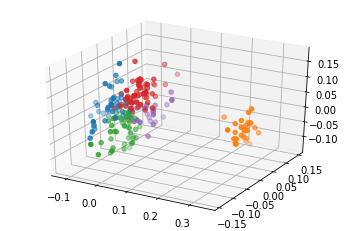

In [17]:
norm_and_run_kmeans(np_x[0])

In [16]:
def single_file_visualizer_no_save(parsed_array):
    fig = go.Figure(data=[go.Surface(z=parsed_array)])
    camera = dict(eye=dict(x=0., y=0., z=1.75))

    fig.update_layout(autosize=True,
                      width=1000, height=700,
                      margin=dict(l=65, r=50, b=65, t=90), 
                      scene_camera=camera, 
                      plot_bgcolor="#FFF",  # Sets background color to white
                      xaxis=dict(
                          linecolor="#BCCCDC",  # Sets color of X-axis line
                          showgrid=False  # Removes X-axis grid lines
                      ),
                      yaxis=dict(
                          linecolor="#BCCCDC",  # Sets color of Y-axis line
                          showgrid=False,  # Removes Y-axis grid lines    
                      )                 
                      )

    fig.update_traces(showscale=False)
    fig.show()

In [ ]:
single_file_visualizer_no_save(np_x[10])

In [26]:
f = open('/content/New folder/1/1614152739528', 'rt')
single_file_visualizer_no_save(single_file_parser_2(f))

In [11]:
import sklearn.pipeline

normalizer = Normalizer()

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma = 5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma = 2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma = 1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma = 0.5, n_components = 100)),
    ("rbf4", RBFSampler(gamma = 0.25, n_components = 100))])

np_x_feat = featurizer.fit_transform(normalizer.fit_transform(np_x_reshaped))
np_x_feat.shape, np_y.shape

((311, 500), (311,))

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    np_x_feat, np_y, test_size = 0.25, random_state = 42)

clf = svm.SVC(kernel='rbf') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3717948717948718
